# Обработка видео
Классификация действий по видео


## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

In [ ]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

     |████████████████████████████████| 2.3MB 2.7MB/s 


## Загрузка и распаковка датасета KTH

In [ ]:
dl = 1
if dl:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if dl:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

--2020-08-31 09:02:28--  http://www.nada.kth.se/cvap/actions/walking.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2020-08-31 09:02:30--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.227.116
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.227.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘walking.zip’

walking.zip             [       <=>          ] 231.21M  3.57MB/s    in 70s     

2020-08-31 09:03:42 (3.31 MB/s) - ‘walking.zip’ saved [242442411]

--2020-08-31 09:03:42--  http://www.nada.kth.se/cvap/actions/jogging.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::

## Подготовка датасета для классификации

In [ ]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [ ]:
SUBSET_LEN = 180
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]
dataset_test = dataset[-SUBSET_LEN:]

print('Train dataset samples (subset):', len(dataset))
print('Test dataset samples (subset):', len(dataset_test))

Train dataset samples (subset): 180
Test dataset samples (subset): 180


## Визуализация кадра из видео

videodata shape: (530, 120, 160, 3)


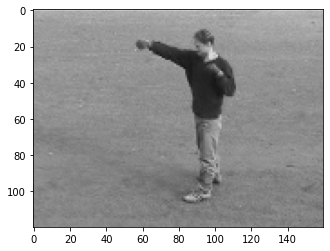

In [ ]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

## Визуализация "движения"

motion shape: (530, 120, 160, 1)


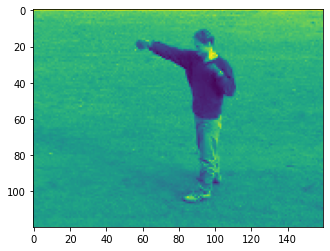

In [ ]:
motion = np.mean(videodata[0:, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

## Создание модели CNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [ ]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 530, 120, 160, 1)
Output shape: (1, 6)


In [ ]:
dataset[0]

('./boxing/person10_boxing_d2_uncomp.avi', 3)

## Подготовка к обучению

In [ ]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.0005
BATCH_SIZE = 8

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

## Цикл обучения модели

In [ ]:
global_step = 0
for ep in range(NUM_EPOCHS):
    # for iter, (fpath, label) in enumerate(dataset):
    for iter in range(len(dataset)):
        fpath = dataset[iter][0]
        fpath2 = dataset_test[iter][0]
        label = dataset[iter][1]
        label2 = dataset_test[iter][1]
        videodata = skvideo.io.vread(fpath)
        videodata_test = skvideo.io.vread(fpath2)
        videodata = videodata.astype(np.float32) / 255.
        videodata_test = videodata_test.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        motion_test = np.mean(videodata_test[1:, ...] - videodata_test[:-1, ...], axis=3, keepdims=True)
        # motion = np.mean(videodata[0:, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        test_x = motion[None, ...]
        y = np.array(label)[None, ...]
        test_y = np.array(label2)[None, ...]

        loss_value = model.fit(x, y,
              batch_size=BATCH_SIZE,
              validation_data=(test_x, test_y),
              shuffle=True)
        
        # loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

            # with writer.as_default():
            #     tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

1/1 [==============================] - 0s 356ms/step - loss: 1.7898 - val_loss: 1.7436
[0/10][0/180] Loss = <tensorflow.python.keras.callbacks.History object at 0x7fd3a67f5588>
1/1 [==============================] - 0s 225ms/step - loss: 1.7921 - val_loss: 1.7913
[0/10][10/180] Loss = <tensorflow.python.keras.callbacks.History object at 0x7fd3a3c51588>
1/1 [==============================] - 0s 180ms/step - loss: 1.8251 - val_loss: 1.8233
[0/10][20/180] Loss = <tensorflow.python.keras.callbacks.History object at 0x7fd3a45577b8>
1/1 [==============================] - 0s 221ms/step - loss: 1.8423 - val_loss: 1.8371
[0/10][30/180] Loss = <tensorflow.python.keras.callbacks.History object at 0x7fd3a3c2e588>
1/1 [==============================] - 0s 202ms/step - loss: 1.8187 - val_loss: 1.8166
[0/10][40/180] Loss = <tensorflow.python.keras.callbacks.History object at 0x7fd3a4557400>
1/1 [==============================] - 0s 164ms/step - loss: 1.6969 - val_loss: 1.6967
[0/10][50/180] Loss = <t

## Тестирование обученной модели

True class: walking
Predicted class: walking


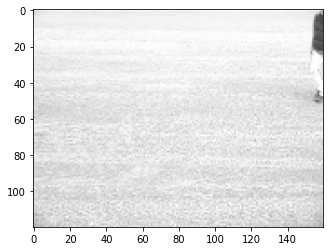

In [ ]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])